# EE 344 — Assignment 2 (Power Plant Regression)

This notebook follows the assignment instructions using the provided dataset `usina_with_outliers.csv`.
I will (1) detect outliers using Cook's Distance, (2) remove them and export `usina.csv`, and then continue with model evaluation and coefficient/feature analysis in later questions.

In [39]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Load dataset (with outliers)
This dataset is customized for this assignment

In [2]:
df = pd.read_csv("usina_with_outliers.csv")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [3]:
df.shape

(9568, 5)

The dataset has 4 input features, including AT, V, AP, RH, and the target is PE.

In [4]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

## Q1: Outlier Detection and Removal using Cook’s Distance

### Q1.1 Model choice and justification

**Model choice:**  
I choose **Linear Regression (OLS)** because Cook’s Distance is an influence measure
specifically defined for linear regression models. Since the goal of this question
is to identify influential outliers, using a standard linear regression model is the
most direct and appropriate choice.

**Library choice:**  
I choose **statsmodels OLS** because it already has built-in tools to compute Cook’s
Distance. This makes it easier to identify outliers without having to manually write
the formula, and the results are straightforward to interpret.

### Q1.2 Identify outliers, remove them, and export clean CSV

In this part, I fit an OLS regression model using all input features and compute
Cook’s Distance for each observation. Outliers are identified using the standard
threshold rule **4 / n**, where *n* is the number of samples. The detected outliers
are removed, and the cleaned dataset is exported as `usina.csv`.

In [5]:
X = df[["AT", "V", "AP", "RH"]]
y = df["PE"]

In [6]:
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()

In [7]:
influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

In [8]:
n = len(df)
threshold = 4 / n
threshold

0.0004180602006688963

In [11]:
outlier = cooks_d > threshold
outlier.sum()

np.int64(120)

Using the threshold **4 / n**, the number of detected outliers is shown above.
These observations are removed in the next step.

In [12]:
df_clean = df.loc[~outlier].copy()
df_clean.shape

(9448, 5)

Export he cleaned dataset with the exact filename `usina.csv`.

In [13]:
df_clean.to_csv("usina.csv", index=False)

In [14]:
pd.read_csv("usina.csv").head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


## Q2: Train/Test Evaluation Before vs After Outlier Removal

In this question, I compare model performance before and after outlier removal using `usina_with_outliers.csv` and `usina.csv`.

All models are evaluated using a 70% / 30% train-test split with a fixed random state.

I train Linear Regression, Ridge Regression, and Lasso Regression on the dataset
that contains outliers, and report both train and test performance.

In [16]:
df_out = pd.read_csv("usina_with_outliers.csv")

X_out = df_out[["AT", "V", "AP", "RH"]]
y_out = df_out["PE"]

X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(
    X_out, y_out, test_size=0.3, random_state=42
)

In [17]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return {
        "train_MAE": mean_absolute_error(y_train, y_train_pred),
        "train_MSE": mean_squared_error(y_train, y_train_pred),
        "train_R2": r2_score(y_train, y_train_pred),
        "test_MAE": mean_absolute_error(y_test, y_test_pred),
        "test_MSE": mean_squared_error(y_test, y_test_pred),
        "test_R2": r2_score(y_test, y_test_pred)
    }

In [18]:
results_out = {}

results_out["Linear"] = evaluate_model(
    LinearRegression(),
    X_out_train, X_out_test,
    y_out_train, y_out_test
)

results_out["Linear"]

{'train_MAE': 5.1986792395786505,
 'train_MSE': 123.384206603329,
 'train_R2': 0.6501705758093679,
 'test_MAE': 5.052457986837265,
 'test_MSE': 125.11338906020671,
 'test_R2': 0.6425738281990965}

In [19]:
lambdas = [0.01, 0.1, 1, 10, 100]

for lam in lambdas:
    results_out[f"Ridge_{lam}"] = evaluate_model(
        Ridge(alpha=lam),
        X_out_train, X_out_test,
        y_out_train, y_out_test
    )

    results_out[f"Lasso_{lam}"] = evaluate_model(
        Lasso(alpha=lam, max_iter=10000),
        X_out_train, X_out_test,
        y_out_train, y_out_test
    )

In [20]:
results_out_df = pd.DataFrame(results_out).T
results_out_df

,train_MAE,train_MSE,train_R2,test_MAE,test_MSE,test_R2
Linear,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
Ridge_0.01,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
Lasso_0.01,5.198858,123.384210,0.650171,5.052626,125.115332,0.642568
Ridge_0.1,5.198680,123.384207,0.650171,5.052459,125.113392,0.642574
Lasso_0.1,5.201739,123.384607,0.650169,5.055348,125.134495,0.642514
Ridge_1,5.198685,123.384207,0.650171,5.052463,125.113421,0.642574
Lasso_1,5.229507,123.421151,0.650066,5.083092,125.338356,0.641931
Ridge_10,5.198737,123.384207,0.650171,5.052513,125.113705,0.642573
Lasso_10,5.540418,126.141514,0.642353,5.408803,128.902136,0.631750
Ridge_100,5.199261,123.384213,0.650171,5.053003,125.116548,0.642565


I repeat the same process using the cleaned dataset after removing outliers.

In [21]:
df_clean = pd.read_csv("usina.csv")

X_clean = df_clean[["AT", "V", "AP", "RH"]]
y_clean = df_clean["PE"]

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42
)

In [22]:
results_clean = {}

results_clean["Linear"] = evaluate_model(
    LinearRegression(),
    X_c_train, X_c_test,
    y_c_train, y_c_test
)

results_clean["Linear"]

{'train_MAE': 3.5963964217310505,
 'train_MSE': 19.864671003981226,
 'train_R2': 0.9313692265834657,
 'test_MAE': 3.6247726076133877,
 'test_MSE': 20.39677245604326,
 'test_R2': 0.9303022187088379}

In [23]:
for lam in lambdas:
    results_clean[f"Ridge_{lam}"] = evaluate_model(
        Ridge(alpha=lam),
        X_c_train, X_c_test,
        y_c_train, y_c_test
    )

    results_clean[f"Lasso_{lam}"] = evaluate_model(
        Lasso(alpha=lam, max_iter=10000),
        X_c_train, X_c_test,
        y_c_train, y_c_test
    )

In [24]:
results_clean_df = pd.DataFrame(results_clean).T
results_clean_df

,train_MAE,train_MSE,train_R2,test_MAE,test_MSE,test_R2
Linear,3.596396,19.864671,0.931369,3.624773,20.396772,0.930302
Ridge_0.01,3.596396,19.864671,0.931369,3.624773,20.396772,0.930302
Lasso_0.01,3.596368,19.864675,0.931369,3.624754,20.396738,0.930302
Ridge_0.1,3.596397,19.864671,0.931369,3.624773,20.396770,0.930302
Lasso_0.1,3.596855,19.865263,0.931367,3.624890,20.392600,0.930316
Ridge_1,3.596400,19.864671,0.931369,3.624774,20.396750,0.930302
Lasso_1,3.605523,19.929852,0.931144,3.631153,20.414755,0.930241
Ridge_10,3.596430,19.864672,0.931369,3.624783,20.396549,0.930303
Lasso_10,4.086632,25.685683,0.911258,4.120464,26.157253,0.910618
Ridge_100,3.596742,19.864758,0.931369,3.624880,20.394626,0.930310


### Discussion

From the results, removing outliers significantly improves model performance.
For all models, test MAE and test MSE decrease noticeably after outlier removal,
while test R² increases from around 0.64 to about 0.93.

This shows that outliers increase both training and testing error and reduce
generalization performance. The dataset without outliers clearly generalizes better.

Ridge regression does not show a strong improvement over standard linear regression,
especially after outliers are removed, since the model is already stable.
Lasso regression is more sensitive to the choice of λ, and large λ values lead to
underfitting and worse performance in this problem.

## Q3: Reliability of Coefficients

In this question, I investigate the reliability of regression coefficients using
the outlier-removed dataset `usina.csv`.

### Q3.1 Method choice and scaling decision

**Model choice:**  
I choose **Linear Regression** because the goal of this question is to examine
the reliability of regression coefficients. Using a standard linear regression model
allows the coefficients to be interpreted directly without any regularizations.

**Library choice:**  
I choose **statsmodels OLS** because it provides coefficient estimates together with standard errors and t-statistics, which are useful for assessing coefficient.

**Scaling decision:**  
I do not scale the input variables or the target variable for this task.
Scaling would change the magnitude of coefficients and make it harder to compare their stability. Since I am interested in how reliable the
original coefficients are, therefore, I keep the data unscaled.

### Q3.2 Implementation and results

I fit an OLS regression model on the cleaned dataset and use the standard errors and t-statistics of the coefficients to assess reliability. A coefficient with a larger absolute t-statistic is considered more reliable, while a coefficient with a smaller absolute t-statistic is considered less reliable.

In [25]:
df_clean = pd.read_csv("usina.csv")

X = df_clean[["AT", "V", "AP", "RH"]]
y = df_clean["PE"]

In [26]:
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()

In [27]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        04:48:41   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.9993      9.743     45.265      0.000     421.902     460.097
AT            -1.9546      0.015   -129.113      0.000      -1.984      -1.925
V             -0.2379      0.007    -33.056      0.000      -0.252      -0.224
AP             0.0746      0.009      7.895      0.000       0.056       0.093
RH            -0.1489      0.004    -36.897      0.000      -0.157      -0.141
==============================================================================
Omnibus:                      107.740   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.435
Skew:                           0.007   Prob(JB):                     1.21e-41
Kurtosis:                       3.692   Cond. No.                     2.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
coef_table = pd.DataFrame({
    "coef": ols_model.params,
    "std_err": ols_model.bse,
    "t_value": ols_model.tvalues
})

coef_table

,coef,std_err,t_value
const,440.999323,9.742711,45.264539
AT,-1.954640,0.015139,-129.113036
V,-0.237885,0.007196,-33.056481
AP,0.074638,0.009454,7.894540
RH,-0.148856,0.004034,-36.897303


### Conclusion

Based on the coefficient table, reliability is evaluated using the absolute
t-statistic of each coefficient.

From the results, **AT** has the largest absolute t-value, indicating that it is
the most reliable coefficient in the model. This suggests that ambient temperature
has a very stable and consistent relationship with power output.

On the other hand, **AP** has the smallest absolute t-value among the input features,
making it the least reliable coefficient. Its effect on the target variable is weaker.

# Q4: Most Important vs Least Important Features

In this question, I identify the most important and least important features
using the outlier-removed dataset `usina.csv`.

### Q4.1 Method choice and scaling decision

**Model choice:**  
I choose **Linear Regression** because feature importance in a linear model can be directly interpreted from the magnitude of the regression coefficients.

**Library choice:**  
I choose **statsmodels OLS** because it provides clear coefficient estimates that are easy to compare once the features are on the same scale.

**Scaling decision:**  
For this task, I **scale the input variables** before fitting the model.
Feature importance is based on comparing coefficient magnitudes, and scaling ensures that all features are measured on the same scale.

The target variable is not scaled, since scaling the target does not affect relative feature importance.

## Q4.2 Implementation and results

I standardize the input features, fit a linear regression model, and compare the absolute values of the coefficients to determine feature importance. The feature with the largest absolute coefficient is considered the most important.

In [30]:
df_clean = pd.read_csv("usina.csv")

X = df_clean[["AT", "V", "AP", "RH"]]
y = df_clean["PE"]

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [32]:
X_scaled_ols = sm.add_constant(X_scaled)
ols_model_scaled = sm.OLS(y, X_scaled_ols).fit()

In [33]:
ols_model_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        05:11:36   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.2997      0.046   9865.884      0.000     454.209     454.390
AT           -14.5566      0.113   -129.113      0.000     -14.778     -14.336
V             -3.0307      0.092    -33.056      0.000      -3.210      -2.851
AP             0.4425      0.056      7.895      0.000       0.333       0.552
RH            -2.1971      0.060    -36.897      0.000      -2.314      -2.080
==============================================================================
Omnibus:                      107.740   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.435
Skew:                           0.007   Prob(JB):                     1.21e-41
Kurtosis:                       3.692   Cond. No.                         4.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
coef_table_scaled = pd.DataFrame({
    "coef": ols_model_scaled.params
})

coef_table_scaled

,coef
const,454.299681
AT,-14.556614
V,-3.030737
AP,0.442513
RH,-2.197120


### Conclusion

Based on the scaled coefficient table, feature importance is determined by comparing the absolute values of the regression coefficients.

From the results, **AT** has the largest absolute coefficient, which indicates that
ambient temperature is the most important feature in the model. This suggests that
changes in temperature have the strongest impact on power output.

In contrast, **AP** has the smallest absolute coefficient after scaling, making it
the least important feature among the input variables. Its effect on the target
variable is relatively small compared to the other features.

## Q5: Regularization Paths

In this question, I analyze how regression coefficients change as the regularization
parameter λ increases, using the outlier-removed and scaled dataset `usina.csv`.

In [35]:
df_clean = pd.read_csv("usina.csv")

X = df_clean[["AT", "V", "AP", "RH"]]
y = df_clean["PE"]

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

I use a log-spaced range of λ values so that both small and large regularization
effects can be observed. This avoids edge cases where coefficients are either
almost unchanged or completely zero.

In [37]:
lambdas = np.logspace(-3, 3, 100)

In [38]:
ridge_coefs = []
lasso_coefs = []

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)

    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

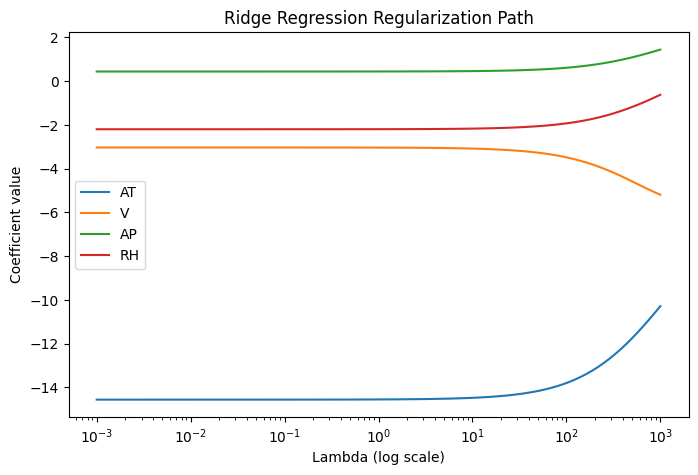

In [40]:
plt.figure(figsize=(8, 5))
for i, col in enumerate(X.columns):
    plt.plot(lambdas, ridge_coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression Regularization Path")
plt.legend()
plt.show()

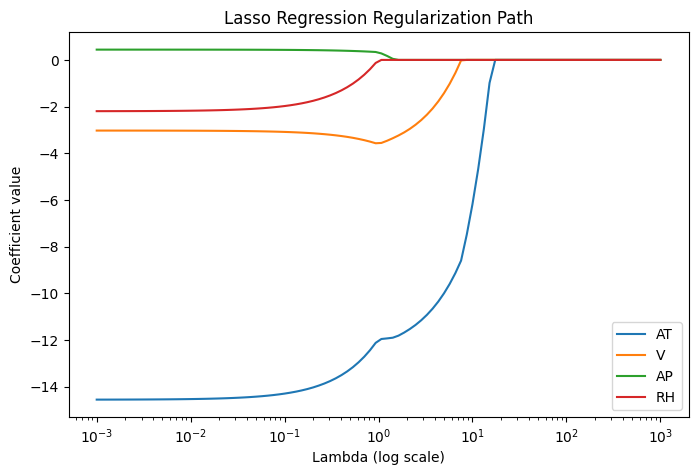

In [41]:
plt.figure(figsize=(8, 5))
for i, col in enumerate(X.columns):
    plt.plot(lambdas, lasso_coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression Regularization Path")
plt.legend()
plt.show()

### Conclusion

From the regularization path plots, different behaviors can be observed for Ridge and Lasso regression.

As λ increases, Ridge regression gradually shrinks all coefficients toward zero,
but they do not become exactly zero. This means Ridge keeps all features in the
model while reducing their impact smoothly.

In contrast, Lasso regression drives some coefficients exactly to zero as λ becomes
large. This shows that Lasso performs feature selection by removing less important
features from the model.

Ridge regression is generally better when multicollinearity exists among input
variables, since it stabilizes coefficient estimates without eliminating features.
Lasso regression is better for feature selection because it can completely remove
features by setting their coefficients to zero.